In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import model_report as mr
import pickle
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
df_test = pd.read_csv('C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Fall 2021\\Capstone A\Data\\test_comp_nouns_v1.csv')

In [2]:
#load data... this data is the optimal 4100 features we identified
X_train = pickle.load(open('tv_train_features_sub.pkl','rb'))
X_test = pickle.load(open('tv_test_features_sub.pkl','rb'))
#X_holdout = pickle.load(open('tv_holdout_features_sub.pkl','rb'))

#load labels
y_train = pickle.load(open('train_label.pkl','rb'))
y_test = pickle.load(open('test_label.pkl','rb'))
#y_holdout = pickle.load(open('holdout_label.pkl','rb'))

#save TFIDFVectorizer to disk
#pickle.dump(tv,open('TFIDFVectorizer.pkl','wb'))

In [3]:
clf = svm.SVC(kernel='linear', probability=True, C=1.0,random_state=1234)
ovo = OneVsOneClassifier(clf)
ovo.fit(X_train,y_train)

OneVsOneClassifier(estimator=SVC(kernel='linear', probability=True,
                                 random_state=1234))

In [4]:
ovo_test_score = ovo.score(X_test,y_test)
print('Test Accuracy:',ovo_test_score)

Test Accuracy: 0.8619127116622943


In [5]:
import model_evaluation_utils as meu
ovo_predictions = ovo.predict(X_test)
meu.get_metrics(true_labels=y_test,predicted_labels=ovo_predictions)

Accuracy: 0.8619
Precision: 0.8662
Recall: 0.8619
F1 Score: 0.8632


In [6]:
unique_classes = list(set(y_test))
meu.display_classification_report(true_labels=y_test,predicted_labels=ovo_predictions,classes=unique_classes)

              precision    recall  f1-score   support

          sx       1.00      0.99      0.99      1345
          ed       0.92      0.87      0.89       783
          os       0.86      0.79      0.82      1393
          sp       0.91      0.87      0.89       494
          bu       0.86      0.87      0.86      2355
          dr       0.99      0.93      0.96       307
          mk       0.72      0.80      0.76      1709

    accuracy                           0.86      8386
   macro avg       0.89      0.87      0.88      8386
weighted avg       0.87      0.86      0.86      8386



Confusion matrix, without normalization
[[1095   18    1   11  197    1   70]
 [   5  681    0    8   38    0   51]
 [   7    1  284    0   10    1    4]
 [  11    4    0  430   43    1    5]
 [ 101   16    0   22 1371    1  198]
 [   1    0    0    1   15 1326    2]
 [  57   20    1    3  233    0 2041]]


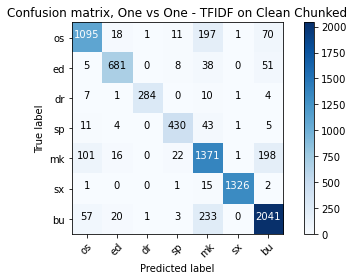

In [7]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,ovo_predictions,labels=['os','ed','dr','sp','mk','sx','bu'])
mr.plot_confusion_matrix(cnf_matrix, classes=['os','ed','dr','sp','mk','sx','bu'],
                      title='Confusion matrix, One vs One - TFIDF on Clean Chunked')

In [12]:
df_test_results = pd.DataFrame(list(zip(df_test['clean_comp_nouns'],y_test,ovo_predictions)),columns = ['terms','category','predicted_label'])
df_test_results['match'] = np.where(df_test_results['category']==df_test_results['predicted_label'],1,0)

In [13]:
rpt = mr.generate_report(df_test_results)
rpt

{'totalSamples': 8386,
 'overallAccuracy': 0.8619127116622943,
 'byCategory': {'sx': {'totalSamples': 1345, 'accuracy': 0.9858736059479554},
  'dr': {'totalSamples': 307, 'accuracy': 0.9250814332247557},
  'sp': {'totalSamples': 494, 'accuracy': 0.8704453441295547},
  'ed': {'totalSamples': 783, 'accuracy': 0.8697318007662835},
  'bu': {'totalSamples': 2355, 'accuracy': 0.8666666666666667},
  'mk': {'totalSamples': 1709, 'accuracy': 0.802223522527794},
  'os': {'totalSamples': 1393, 'accuracy': 0.7860732232591529}}}

In [14]:
#here we can see that the misclassifications of sex equate to the counts in the confusion matrix
df_test_results[(df_test_results.predicted_label == 'sx') & (df_test_results.match == 0)].groupby('category').size()

category
dr    1
mk    1
os    1
sp    1
dtype: int64

In [16]:
#let's look at some of the misclassifications to get an idea of why they were misclassified
pd.set_option('display.max_colwidth', None)
df_test_results[(df_test_results.predicted_label == 'sx') & (df_test_results.match == 0)]

terms  \
2102                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [17]:
# #save model file
filename = 'ovo_comp_nouns_v1.sav'
pickle.dump(ovo,open(filename,'wb'))